# NFL 49ers - Check Retention Scores
* StellarAlgo Data Science
* Grant Donst
* Aug 23, 2022

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
from pycaret.classification import *

### Let's grab the training and eval datasets:

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_eval = pd.read_csv("./data/eval.csv")

In [3]:
df_train = pd.concat([df_train, df_eval])

In [4]:
df_train["year"].value_counts()

2019    10155
Name: year, dtype: int64

### Let's set up our new model:

In [5]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentDate"
    ],
    ignore_features=[
        "dimCustomerMasterId",
        "productGrouping",
        "year"
    ],
    numeric_features=[
        "attendancePercent", 
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "totalSpent"
    ],
    silent=True,
    verbose=False
);

best_model = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9723,0.7000,0.9995,0.9727,0.9860,0.0370,0.0756,1.1620


### Let's finalize our new model so it can be used to make predictions:

In [6]:
final_model = create_model(best_model)
new_retention_model = finalize_model(final_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9722,0.6420,1.0000,0.9722,0.9859,0.0000,0.0000
1,0.9687,0.7107,0.9964,0.9721,0.9841,-0.0062,-0.0100
2,0.9722,0.7500,1.0000,0.9722,0.9859,0.0000,0.0000
3,0.9745,0.6721,1.0000,0.9744,0.9871,0.1502,0.2850
4,0.9745,0.6684,1.0000,0.9744,0.9871,0.1502,0.2850
5,0.9722,0.7626,1.0000,0.9722,0.9859,0.0000,0.0000
6,0.9710,0.7461,0.9988,0.9722,0.9853,-0.0022,-0.0058
7,0.9722,0.7530,1.0000,0.9722,0.9859,0.0000,0.0000
8,0.9722,0.6254,1.0000,0.9722,0.9859,0.0000,0.0000


/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


### Let's also load the model used in retention for production:

In [7]:
prod_retention_model = load_model("./models/model")

Transformation Pipeline and Model Successfully Loaded


### Let's use the new and existing model to make predictions on the 2022 season:

In [8]:
inference_data = pd.read_csv("./data/inference_data.csv")
inference_data.columns = ['attendancePercent', 'clientcode', 'dimCustomerMasterId', 'distToVenue', 'isNextYear_Buyer', 'lkupclientid',
                          'missed_games_1', 'missed_games_2', 'missed_games_over_2', 'productGrouping', 'recency', 'recentDate',
                          'renewedBeforeDays', 'source_tenure', 'totalSpent', 'year']

inference_data = inference_data.loc[inference_data['lkupclientid']==112]

In [9]:
inference_data["year"].value_counts()

2021    9873
Name: year, dtype: int64

### Let's use our model to make predictions on the inference data:

In [10]:
df_new_predictions = predict_model(new_retention_model, data=inference_data, raw_score=True)
df_prod_predictions = predict_model(prod_retention_model, data=inference_data, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9448,0.6542,0.9975,0.9469,0.9716,0.0325,0.0701


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9391,0.6527,0.9896,0.9483,0.9685,0.0688,0.0886


In [11]:
df_new_predictions.head()

,attendancePercent,clientcode,dimCustomerMasterId,distToVenue,isNextYear_Buyer,lkupclientid,missed_games_1,missed_games_2,missed_games_over_2,productGrouping,recency,recentDate,renewedBeforeDays,source_tenure,totalSpent,year,Label,Score_0,Score_1
0,0.611111,nflvikings,261672,0,1,112,1,2,0,Full Season,1,2021-12-09,214,19345,7680.0,2021,1,0.0003,0.9997
1,0.000000,nflvikings,2993009,0,1,112,0,0,1,Full Season,0,1970-01-01,214,5475,79920.0,2021,1,0.0005,0.9995
2,1.111111,nflvikings,3162990,0,1,112,0,0,0,Full Season,0,2022-01-09,213,9490,1740.0,2021,1,0.0081,0.9919
3,0.333333,nflvikings,3164410,0,1,112,0,1,1,Full Season,5,2022-01-09,214,1460,2740.0,2021,1,0.0448,0.9552
4,0.000000,nflvikings,3165226,0,1,112,0,0,1,Full Season,0,1970-01-01,214,1825,2740.0,2021,1,0.0565,0.9435


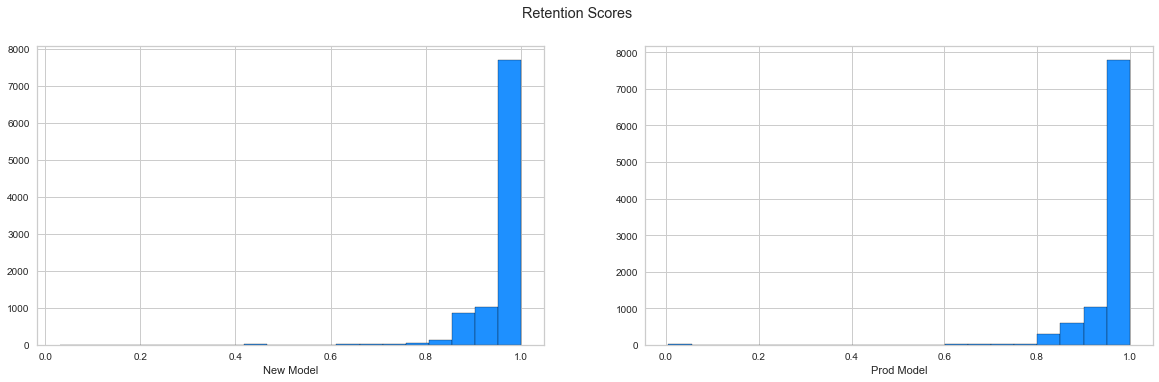

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Retention Scores')
ax1.hist(df_new_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax2.hist(df_prod_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax1.set_xlabel('New Model')
ax2.set_xlabel('Prod Model')

fig.figure.set_figwidth(20)

In [13]:
df_new_predictions["Score_1"].value_counts(bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

(0.9, 1.0]       8872
(0.8, 0.9]        836
(0.7, 0.8]         85
(0.6, 0.7]         40
(0.4, 0.5]         14
(-0.001, 0.1]       8
(0.5, 0.6]          6
(0.2, 0.3]          5
(0.3, 0.4]          4
(0.1, 0.2]          3
Name: Score_1, dtype: int64

### There are a large number of fans in the 0 - 0.1 score bucket, let's run a pandas profile on the dataset to check data quality:

In [14]:
# generate a pandas profile report on the dataset
profile = ProfileReport(inference_data, minimal=True)
profile.to_file("pandas-profile-report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
df_train["recency"].value_counts(bins=10)

(-0.009000000000000001, 0.8]    6686
(0.8, 1.6]                      1101
(1.6, 2.4]                       614
(2.4, 3.2]                       551
(3.2, 4.0]                       402
(5.6, 6.4]                       385
(4.8, 5.6]                       322
(6.4, 7.2]                        81
(7.2, 8.0]                        13
(4.0, 4.8]                         0
Name: recency, dtype: int64